In [ ]:
%%time
import numpy as np

N,D_in,H,D_out = 64,1000,100,10 
x= np.random.randn(N, D_in)
y=np.random.randn(N,D_out)
w1= np.random.randn(D_in,H)
w2=np.random.randn(H,D_out)
LR=1e-6


for t in range(400):
    # 순전파 단계 
    h=x.dot(w1)
    h_relu=np.maximum(h,0)
    y_pred=h_relu.dot(w2)

    # loss 를 계산하고 출력한다.
    loss= np.square(y_pred-y).sum()
    print(t, loss)

    #손실에 따른 w1,w2의 변화도를 계산하고 역전파합니다.
    grad_y_pred=2.0*(y_pred-y)
    grad_w2=h_relu.T.dot(grad_y_pred)
    grad_h_relu=grad_y_pred.dot(w2.T)
    grad_h=grad_h_relu.copy()
    grad_h[h<0]=0
    grad_w1=x.T.dot(grad_h)

    #가중치를 갱신합니다 
    w1-=LR*grad_w1
    w2-=LR*grad_w2




In [ ]:
import torch 
dtype=torch.float
device=torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)
N,D_in, H,D_out =64,1000,100,10
x=torch.randn(N,D_in,device=device,dtype=dtype)
y=torch.randn(N,D_out,device=device,dtype=dtype)
# 무작위로 가중치를 초기화하기
w1=torch.randn(D_in,H,device=device,dtype=dtype)
w2=torch.randn(H,D_out,device=device,dtype=dtype)
LR=1e-5/11
print(x.shape,w1.shape,y.shape,w2.shape)
for t in range(500):
    h=x.matmul(w1)
    h_relu=h.clamp(min=0)
    y_pred=h_relu.matmul(w2)

    # loss 를 계산하고 출력한다
    loss=(y_pred-y).pow(2).sum().item()
    if t%10==0:
        print(t,loss)
    # 손실에 따른 w1,w2의 변화도를 계산하고 역전파합니다
    grad_y_pred=2.0*(y_pred-y)
    grad_w2=h_relu.t().matmul(grad_y_pred)
    grad_h_relu=grad_y_pred.matmul(w2.t())
    grad_h=grad_h_relu.clone()
    grad_h[h<0]=0
    grad_w1=x.t().matmul(grad_h)

    # 경사하강법을 사용하여 가중치를 갱신한다.
    w1-=LR*grad_w1
    w2-=LR*grad_w2

In [ ]:
import torch 
dtype=torch.float
device=torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)
N,D_in, H,D_out =64,1000,100,10
x=torch.randn(N,D_in,device=device,dtype=dtype)
y=torch.randn(N,D_out,device=device,dtype=dtype)
# 무작위로 가중치를 초기화하기
w1=torch.randn(D_in,H,device=device,dtype=dtype,requires_grad=True)
w2=torch.randn(H,D_out,device=device,dtype=dtype,requires_grad=True)
LR=1e-5/11
print(x.shape,w1.shape,y.shape,w2.shape)
for t in range(500):
    # h=x.matmul(w1)
    # h_relu=h.clamp(min=0)
    # y_pred=h_relu.matmul(w2)
    # 중간단계들에 reference를 가지고 있을 필요가없으므로 한번에 구한다
    y_pred=x.mm(w1).clamp(min=0).mm(w2)
    # loss 를 계산하고 출력한다
    loss=(y_pred-y).pow(2).sum()
    if t%10==0:
        print(t,loss.item())
    # 손실에 따른 w1,w2의 변화도를 계산하고 역전파합니다
    # grad_y_pred=2.0*(y_pred-y)
    # grad_w2=h_relu.t().matmul(grad_y_pred)
    # grad_h_relu=grad_y_pred.matmul(w2.t())
    # grad_h=grad_h_relu.clone()
    # grad_h[h<0]=0
    # grad_w1=x.t().matmul(grad_h)
    loss.backward()
    # 경사하강법을 사용하여 가중치를 갱신한다.
    with torch.no_grad():
        w1-=LR*w1.grad
        w2-=LR*w2.grad
        #가중치 갱신후에는 수동으로 변화도를 0으로 만들어준다.
        w1.grad.zero_()
        w2.grad.zero_()

In [ ]:
# -*- coding: utf-8 -*-
import torch

# N은 배치 크기이며, D_in은 입력의 차원입니다;
# H는 은닉층의 차원이며, D_out은 출력 차원입니다.
N, D_in, H, D_out = 64, 1000, 100, 10

# 입력과 출력을 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# nn 패키지를 사용하여 모델을 순차적 계층(sequence of layers)으로 정의합니다.
# nn.Sequential은 다른 Module들을 포함하는 Module로, 그 Module들을 순차적으로
# 적용하여 출력을 생성합니다. 각각의 Linear Module은 선형 함수를 사용하여
# 입력으로부터 출력을 계산하고, 내부 Tensor에 가중치와 편향을 저장합니다.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# 또한 nn 패키지에는 널리 사용하는 손실 함수들에 대한 정의도 포함하고 있습니다;
# 여기에서는 평균 제곱 오차(MSE; Mean Squared Error)를 손실 함수로 사용하겠습니다.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # 순전파 단계: 모델에 x를 전달하여 예상되는 y 값을 계산합니다. Module 객체는
    # __call__ 연산자를 덮어써(override) 함수처럼 호출할 수 있게 합니다.
    # 이렇게 함으로써 입력 데이터의 Tensor를 Module에 전달하여 출력 데이터의
    # Tensor를 생성합니다.
    y_pred = model(x)

    # 손실을 계산하고 출력합니다. 예측한 y와 정답인 y를 갖는 Tensor들을 전달하고,
    # 손실 함수는 손실 값을 갖는 Tensor를 반환합니다.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # 역전파 단계를 실행하기 전에 변화도를 0으로 만듭니다.

    # 역전파 단계: 모델의 학습 가능한 모든 매개변수에 대해 손실의 변화도를
    # 계산합니다. 내부적으로 각 Module의 매개변수는 requires_grad=True 일 때
    # Tensor 내에 저장되므로, 이 호출은 모든 모델의 모든 학습 가능한 매개변수의
    # 변화도를 계산하게 됩니다.
    loss.backward()

    # 경사하강법(gradient descent)를 사용하여 가중치를 갱신합니다. 각 매개변수는
    # Tensor이므로 이전에 했던 것과 같이 변화도에 접근할 수 있습니다.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    model.zero_grad()

In [ ]:
# -*- coding: utf-8 -*-
import torch

# N은 배치 크기이며, D_in은 입력의 차원입니다;
# H는 은닉층의 차원이며, D_out은 출력 차원입니다.
N, D_in, H, D_out = 64, 1000, 100, 10

# 입력과 출력을 저장하기 위해 무작위 값을 갖는 Tensor를 생성합니다.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# nn 패키지를 사용하여 모델과 손실 함수를 정의합니다.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# optim 패키지를 사용하여 모델의 가중치를 갱신할 Optimizer를 정의합니다.
# 여기서는 Adam을 사용하겠습니다; optim 패키지는 다른 다양한 최적화 알고리즘을
# 포함하고 있습니다. Adam 생성자의 첫번째 인자는 어떤 Tensor가 갱신되어야 하는지
# 알려줍니다.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    # 순전파 단계: 모델에 x를 전달하여 예상되는 y 값을 계산합니다.
    y_pred = model(x)

    # 손실을 계산하고 출력합니다.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # 역전파 단계 전에, Optimizer 객체를 사용하여 (모델의 학습 가능한 가중치인)
    # 갱신할 변수들에 대한 모든 변화도를 0으로 만듭니다. 이렇게 하는 이유는
    # 기본적으로 .backward()를 호출할 때마다 변화도가 버퍼(buffer)에 (덮어쓰지 않고)
    # 누적되기 때문입니다. 더 자세한 내용은 torch.autograd.backward에 대한 문서를
    # 참조하세요.
    optimizer.zero_grad()

    # 역전파 단계: 모델의 매개변수에 대한 손실의 변화도를 계산합니다.
    loss.backward()

    # Optimizer의 step 함수를 호출하면 매개변수가 갱신됩니다.
    optimizer.step()

In [ ]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in,H,D_out):
        super(TwoLayerNet,self).__init__()
        self.linear1=torch.nn.Linear(D_in,H)
        self.linear2=torch.nn.Linear(H,D_out)
    
    def forward(self,x):
        '''순전파 함수에서는 입력 데이터의 tensor를 받고 출력 데이터의 tensor를 반환해야 한다.
        Tensor상의 임의의 연산자뿐만 아니라 생성자에서 정의한 Module도 사용할 수 있다.'''
        h_relu = self.linear1(x).clamp(min=0)
        y_pred=self.linear2(h_relu)
        return y_pred

N, D_in, H, D_out = 64, 1000, 100, 10
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)
model = TwoLayerNet(D_in, H, D_out)
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    y_pred = model(x)
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### pytorch 
- 제어 흐름(Contorl Flow)+가중치공유(weight sharing)
```
동적 그래프와 가중치 공유의 예로, 매우 이상한 모델을 구현해보겟다.각 순전파 단계에서 많은 은닉 계층을 갖는 완전히 연결(fully connected)된 Relu신경망이 무자구이로 0~3 사이의 숫자를 선택하고, 가장 안쪽(innerMost)의 
은닉층들을 계산하기 위해 동일한 가중치를 여러 번 재사용합니다 

이 모델에서는 일반적인 Python 제어 흐름을 사용하여 반복을 구현할 수 있으며, 순전파 단계를 정의할 때 단지 동일한 module 을 여러번 재사용함으로써 내부계층들 간의 가중치 공유를 구현할 수 있습니다.
이러한 모델을 Moduel을 상속받는 서브클래스로 간단히 구현해보겟습니다.
```

In [ ]:
import random
import pandas as pd
class DynamicNet(torch.nn.Module):
    def __init__(self, D_in,H,D_out):
        super(DynamicNet,self).__init__()
        self.input_linear=torch.nn.Linear(D_in,H)
        self.middle_linear=torch.nn.Linear(H,H)
        self.output_linear=torch.nn.Linear(H,D_out)

    def forward(self, x):
        h_relu=self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0,3)):
            h_relu=self.middle_linear(h_relu).clamp(min=0)
        y_pred=self.output_linear(h_relu)
        return y_pred


N,D_in,H,D_out=64,1000,100,10

x=torch.randn(N,D_in)
y=torch.randn(N,D_out)

medel=DynamicNet(D_in,H,D_out)

# 손실함수와 옵티마이저 생성 
# -> 이 요상한 모델은 SGD로 구할 수 없으니 momentum을 이용한다고 한다.
criterion=torch.nn.MSELoss(reduction='sum')
optimizer=torch.optim.SGD(model.parameters(),lr=1e-4,momentum=0.9)

for t in range(500):
    y_pred=model(x)
    loss=criterion(y_pred,y)
    if t%100==0:
        print(t,loss.item())
    # 변화도를 0으로 만들고 역전파 단계를 수행하고 가중치를 갱신한다.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    

### MNiST 데이터 준비 


In [ ]:
from pathlib import Path
import requests

Data_path=Path('data')
PATH=Data_path/'mnist'
PATH.mkdir(parents=True,exist_ok=True)

URL='https://deeplearning.net/data/mnist/'
FileName='mnist.pkl.gz'

if not(PATH/FileName).exists():
    content=requests.get(URL+FileName).content
    (PATH/FileName).open('wb').write(content)


In [114]:
import tensorflow as tf
data_train,data_test=tf.keras.datasets.mnist.load_data()
image_train,label_train=data_train
image_test,label_test=data_test

AttributeError: 'tuple' object has no attribute 'shape'

torch.Size([60000, 28, 28])


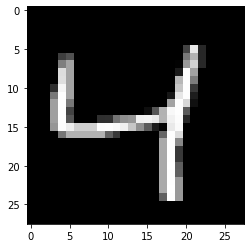

In [103]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(image_train[2].reshape((28,28)),cmap='gray')
print(x_train.shape)

In [108]:
import torch
x_train,y_train=data_train
x_vaild,y_vaild=data_test
x_train,y_train,x_vaild,y_vaild=map(torch.tensor,(x_train,y_train,x_vaild,y_vaild))
print( x_train.shape)
x_train,x_train.shape,y_train.min(),y_train.max()
print(x_train,y_train)
print(x_train.reshape(-1,28*28).shape)
print(y_train.min(),y_train.max())

torch.Size([60000, 28, 28])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0, 

In [106]:
import math
w1= torch.randn(784,10)/math.sqrt(784)
w1.requires_grad_()
bias=torch.zeros(10,requires_grad=True)
w1

tensor([[-0.0341, -0.0085, -0.0288,  ...,  0.0053, -0.0223,  0.0477],
        [ 0.0039, -0.0407, -0.0295,  ...,  0.0187, -0.0147,  0.0085],
        [-0.0205,  0.0411,  0.0428,  ..., -0.0182, -0.0453, -0.0073],
        ...,
        [ 0.0024,  0.0421,  0.0479,  ...,  0.0418,  0.0133,  0.0039],
        [ 0.0180,  0.0161, -0.0036,  ..., -0.0738,  0.0323, -0.0253],
        [-0.0151,  0.0097,  0.0279,  ..., -0.0350, -0.0083,  0.0206]],
       requires_grad=True)

In [122]:
def log_softmax(x):
    return x-x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb.mm(w1)+bias)

In [123]:
bs=64
xb=x_train.reshape(-1,(28*28))[0:bs]
print(xb.shape)
preds=model(xb)

preds.shape

torch.Size([64, 784])


RuntimeError: Expected object of scalar type Byte but got scalar type Float for argument #2 'mat2' in call to _th_mm

###TensorBoard 로 모델 , 데이터 , 학습 시각화하기
---

1. 데이터를 읽고 적적히 변화합니다.
2. TensorBoard를 set up 합니다.
3. TensorBoard에 write 합니다
4. TensorBoard를 사용하여 모델 구조를 살펴봅니다
5. 약가의 코드를 추가하여 TensorBoard에서 이전 듀토리얼에서 만든 시각화의 대화식 버전을 만듭니다
---
- 학습데이터를 검사하는 몇가지 방법
- 학습에 따른 모델의 성능을 추적하는 방법
- 학습이 완료된 모델의 성능 평가하는 방법


In [124]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
# transform 
transform =transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
#datasets
trainset=torchvision.datasets.FashionMNIST('./data',download=True,train=True,transform=transform)
testset=torchvision.datasets.FashionMNIST('./data',download=True,train=False,transform=transform)
#dataloaders
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)

#분류 결과를 위한 상수 
classes=('T-shirt/top','Trouse','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Bot')
#이미지를 보여주기 위한 헬퍼 함수
def matplotlib_imshow(img,one_channel=False):
    if one_channel:
        img=img.mean(dim=0)
    img=img/2+0.5
    npimg=img.numpy()
    if one_channel:
        plt.imshow(npimg,cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg,(1,2,0)))


0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz
 98%|█████████▊| 25952256/26421880 [00:18<00:00, 5343284.25it/s]Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw

0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz

 56%|█████▌    | 16384/29515 [00:00<00:00, 58291.88it/s]

0it [00:00, ?it/s]Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw


  0%|          | 0/4422102 [00:00<?, ?it/s]

  0%|          | 16384/4422102 [00:00<01:16, 57274.73it/s]

  1%|          | 40960/4422102 [00:01<01:08, 63620.77it/s]

  2%|▏         | 98304/4422102 [00:01<00:54, 80037.93it/s]

  5%|▍         | 204800/4422102 [00:01<00:40, 104626.59it/s]

 10%|▉         | 425984/4422102 [00:02<00:28, 14126

In [131]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*4*4,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*4*4)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

net=Net()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.001)

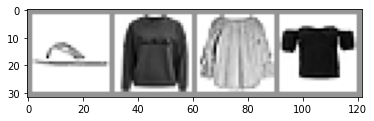

In [132]:
# TensorBoard 설정

from torch.utils.tensorboard import SummaryWriter
# 기본 log_dir 은 runs이며 여기서는 더 구체적으로 지정하였다. 
writer=SummaryWriter('runs/fashion_mnist_experiment_1')

# TensorBoard 에 기록하기 

dataiter=iter(trainloader)
images,labels=dataiter.next()
#이미지 그리드를 만듭니다 
img_grid=torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid,one_channel=True)

# 텐서보드에 기록합니다 
writer.add_image('four_fashion_mnist_images',img_grid)


In [133]:
writer.add_graph(net,images)
writer.close()